In [1]:
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from typing import Any
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

In [2]:
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [3]:
class LIFSurrogate(nn.Module):
    def __init__(self, beta, threshold=1.0, k=25):


        super(LIFSurrogate, self).__init__()

        # initialize decay rate beta and threshold
        self.beta = beta
        self.threshold = threshold
        self.surrogate_func = self.LocalZO.apply

    # the forward function is called each time we call Leaky
    def forward(self, input_, mem):
        spk = self.surrogate_func((mem-self.threshold))  # call the Heaviside function
        reset = (spk - self.threshold).detach()
        mem = self.beta * mem + input_ - reset
        return spk, mem


    # class LocalZO(torch.autograd.Function):
    #     @staticmethod
    #     def forward(ctx, mem, num_samples=5, p_radius=0.05):
    #         dist = MultivariateNormal(loc=torch.zeros(mem.shape[-1]), covariance_matrix=torch.eye(mem.shape[-1]))
    #         grad = torch.zeros_like(mem).to(device)
            
    #         for i in range(5):
    #             z = dist.sample().to(device)
    #             grad += (torch.abs(mem) < p_radius * torch.abs(z)) * torch.abs(z) / (2 * p_radius)

    #         torch.div(grad, num_samples)

    #         ctx.save_for_backward(grad)
    #         out = (mem > 0).float()
            
    #         return out
        

    #     @staticmethod
    #     def backward(ctx: Any, grad_output) -> Any:
    #         (grad,_) = ctx.saved_tensors
    #         grad_input = grad_output.clone()

    #         return grad * grad_input, None

In [4]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95


# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = surrogate.custom_surrogate(self.LocalZO.apply)

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        # self.lif1 = LIFSurrogate(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        # self.lif2 = LIFSurrogate(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

    class LocalZO(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input):
            delta = 0.05
            out = (input > 0).float()
            L = torch.tensor([delta])
            ctx.save_for_backward(input, L)
            return out

        @staticmethod
        def backward(ctx, grad_output):
            (input, others) = ctx.saved_tensors
            delta = others[0].item()
            grad_input = grad_output.clone()
            
            sample_size=5
            abs_z = torch.abs(torch.randn((sample_size,)+input.size(), device=torch.device('cuda'), dtype=torch.float))
            t=torch.abs(input[None,:,:])< abs_z*delta
            grad_input=grad_input*torch.mean(t*abs_z, dim=0)/(2*delta)

            return grad_input, None    
        # @staticmethod
        # def forward(ctx, mem, num_samples=5, p_radius=0.05):
        #     dist = MultivariateNormal(loc=torch.zeros(mem.shape[-1]), covariance_matrix=torch.eye(mem.shape[-1]))
        #     grad = torch.zeros_like(mem).to(device)
            
        #     for i in range(5):
        #         z = dist.sample().to(device)
        #         grad += (torch.abs(mem) < p_radius * torch.abs(z)) * torch.abs(z) / (2 * p_radius)

        #     torch.div(grad, num_samples)

        #     ctx.save_for_backward(grad)
        #     out = (mem > 0).float()
            
        #     return out
        

        # @staticmethod
        # def backward(ctx: Any, grad_output) -> Any:
        #     (grad,_) = ctx.saved_tensors
        #     grad_input = grad_output.clone()

            return grad * grad_input, None
# Load the network onto CUDA if available
net = Net().to(device)

In [5]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [6]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

TypeError: Net.LocalZO.forward() takes 2 positional arguments but 4 were given

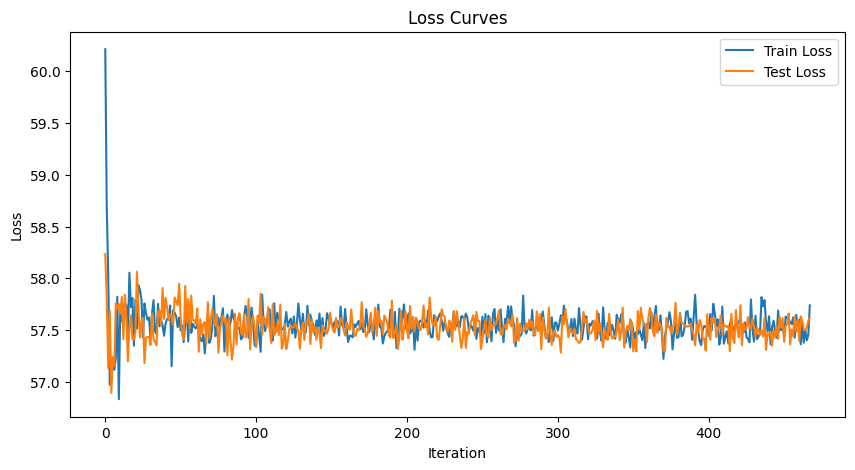

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()